In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import time
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import os
rnd = 42
np.random.seed(rnd)
torch.manual_seed(rnd)
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [28]:
def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i].replace('%s=' % real_feature_names[j], '')] = i
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i].replace('%s=' % real_feature_names[j], '')] = i
            i += 1
        else:
            j += 1
    return features_map

def get_real_feature_names(rdf, numeric_columns, class_name):
    if isinstance(class_name, list):
        real_feature_names = [c for c in rdf.columns if c in numeric_columns and c not in class_name]
        real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c not in class_name]
    else:
        real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
        real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    if not isinstance(class_name, list):
        dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
        class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
        dfY = df[class_name].map(class_name_map)
        df = pd.concat([dfX, dfY], axis=1)
        df =df.reindex(dfX.index)
        feature_names = list(dfX.columns)
        class_values = sorted(class_name_map)
    else: # isinstance(class_name, list)
        dfX = pd.get_dummies(df[[c for c in df.columns if c not in class_name]], prefix_sep='=')
        # class_name_map = {v: k for k, v in enumerate(sorted(class_name))}
        class_values = sorted(class_name)
        dfY = df[class_values]
        df = pd.concat([dfX, dfY], axis=1)
        df = df.reindex(dfX.index)
        feature_names = list(dfX.columns)
    return df, feature_names, class_values

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

class_name = 'default'
# Load and transform dataset 
df = pd.read_csv('./data/german_credit.csv', skipinitialspace=True, na_values='?', keep_default_na=True)
df.columns = [c.replace('=', '') for c in df.columns]

df = remove_missing_values(df)
numeric_columns = get_numeric_columns(df)
rdf = df
df, feature_names, class_values = one_hot_encoding(df, class_name)
real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
features_map = get_features_map(feature_names, real_feature_names)
std = MinMaxScaler(feature_range=(-1,1))
df.iloc[:,[0,1,4]] = std.fit_transform(df.values[:,[0,1,4]])
hot_enc = OneHotEncoder(handle_unknown='ignore')
for i in [2,3,5,6]:
    df.iloc[:,i] = [df.columns[i]+'='+df.iloc[:,i].values.astype(str)[j] for j in range(len(df))] 
hot_enc.fit(df.iloc[:,[2,3,5,6]])
df[np.hstack(hot_enc.categories_).tolist()]=hot_enc.transform(df.iloc[:,[2,3,5,6]]).toarray().astype(int)
df = df.drop(list(df.columns[[2,3,5,6]]), axis=1, inplace=False)
y = df['default'].astype(int)
df.drop(['default'], axis=1, inplace=True)

l = list(df.columns)
for i in range(len(l)):
    l[i] = l[i].replace('<', 'm')
    l[i] = l[i].replace('>', 'M')
df.columns = l

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y, random_state=rnd)

In [29]:
df

,duration_in_month,credit_amount,age,account_check_status=0 m= ... m 200 DM,account_check_status=m 0 DM,account_check_status=M= 200 DM / salary assignments for at least 1 year,account_check_status=no checking account,credit_history=all credits at this bank paid back duly,credit_history=critical account/ other credits existing (not at this bank),credit_history=delay in paying off in the past,credit_history=existing credits paid back duly till now,credit_history=no credits taken/ all credits paid back duly,purpose=(vacation - does not exist?),purpose=business,purpose=car (new),purpose=car (used),purpose=domestic appliances,purpose=education,purpose=furniture/equipment,purpose=radio/television,purpose=repairs,purpose=retraining,savings=.. M= 1000 DM,savings=... m 100 DM,savings=100 m= ... m 500 DM,savings=500 m= ... m 1000 DM,savings=unknown/ no savings account,present_emp_since=.. M= 7 years,present_emp_since=... m 1 year,present_emp_since=1 m= ... m 4 years,present_emp_since=4 m= ... m 7 years,present_emp_since=unemployed,personal_status_sex=female : divorced/separated/married,personal_status_sex=male : divorced/separated,personal_status_sex=male : married/widowed,personal_status_sex=male : single,other_debtors=co-applicant,other_debtors=guarantor,other_debtors=none,property=if not A121 : building society savings agreement/ life insurance,"property=if not A121/A122 : car or other, not in attribute 6",property=real estate,property=unknown / no property,other_installment_plans=bank,other_installment_plans=none,other_installment_plans=stores,housing=for free,housing=own,housing=rent,job=management/ self-employed/ highly qualified employee/ officer,job=skilled employee / official,job=unemployed/ unskilled - non-resident,job=unskilled - resident,telephone=none,"telephone=yes, registered under the customers name",foreign_worker=no,foreign_worker=yes,installment_as_income_perc=1,installment_as_income_perc=2,installment_as_income_perc=3,installment_as_income_perc=4,present_res_since=1,present_res_since=2,present_res_since=3,present_res_since=4,credits_this_bank=1,credits_this_bank=2,credits_this_bank=3,credits_this_bank=4,people_under_maintenance=1,people_under_maintenance=2
0,-0.941176,-0.898867,0.714286,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0
1,0.294118,-0.372620,-0.892857,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0
2,-0.764706,-0.796853,0.071429,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1
3,0.117647,-0.160119,-0.071429,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1
4,-0.411765,-0.491581,0.214286,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.764706,-0.836470,-0.571429,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0
996,-0.235294,-0.603059,-0.250000,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0
997,-0.764706,-0.939034,-0.321429,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0
998,0.205882,-0.824475,-0.857143,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0

XGBOOST
train acc: 0.93625
test acc: 0.75
RF
train acc: 0.875
test acc: 0.77
SVC
train acc: 0.7975
test acc: 0.765


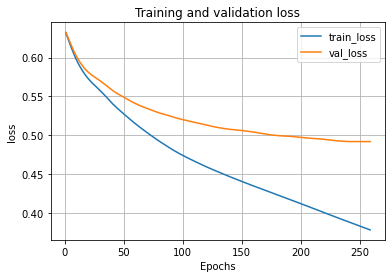

NN
25/25 [==============================] - 0s 934us/step
0.82875
7/7 [==============================] - 0s 1ms/step
0.76
---------------


In [30]:
# XGBOOST
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(n_estimators=10, reg_lambda=1, use_label_encoder=False, eval_metric='logloss')
clf_xgb.fit(X_train, y_train)
pickle.dump(clf_xgb,open('./blackboxes/german_xgboost.p','wb'))
clf_xgb = pickle.load(open('./blackboxes/german_xgboost.p','rb'))
def predict(x, return_proba=False):
    if return_proba:
        return clf_xgb.predict_proba(x)[:,1].ravel()
    else: return clf_xgb.predict(x).ravel().ravel()
y_train_pred = predict(X_train)
y_test_pred = predict(X_test)
print('XGBOOST')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

# RF
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=7,random_state=rnd)
clf_rf.fit(X_train, y_train)
pickle.dump(clf_rf,open('./blackboxes/german_rf.p','wb'))
clf_rf = pickle.load(open('./blackboxes/german_rf.p','rb'))
def predict(x, return_proba=False):
    if return_proba:
        return clf_rf.predict_proba(x)[:,1].ravel()
    else: return clf_rf.predict(x).ravel().ravel()
y_test_pred = predict(X_test, return_proba=True)
y_train_pred = predict(X_train, return_proba=True)
print('RF')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

# SVC
from sklearn.svm import SVC
clf_svc = SVC(gamma='auto', probability=True)
clf_svc.fit(X_train, y_train)
pickle.dump(clf_svc,open('./blackboxes/german_svc.p','wb'))
clf_svc = pickle.load(open('./blackboxes/german_svc.p','rb'))
def predict(x, return_proba=False):
    if return_proba:
        return clf_svc.predict_proba(x)[:,1].ravel()
    else: return clf_svc.predict(x).ravel().ravel()
y_train_pred = predict(X_train, return_proba=True)
y_test_pred = predict(X_test, return_proba=True)
print('SVC')
print('train acc:',np.mean(np.round(y_train_pred)==y_train))
print('test acc:',np.mean(np.round(y_test_pred)==y_test))

# NN tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
BATCH_SIZE = 1024
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)
clf_nn = keras.Sequential([
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=5, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])
early_stopping = EarlyStopping(patience=5)
clf_nn.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = clf_nn.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10000,
    callbacks=[early_stopping],
    verbose=0
    )
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.grid()
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history, 'loss')
clf_nn.save_weights('./blackboxes/german_tf_nn')
from sklearn.metrics import accuracy_score
clf_nn.load_weights('./blackboxes/german_tf_nn')
clf_nn.trainable = False
def predict(x, return_proba=False):
    if return_proba:
        return clf_nn.predict(x).ravel()
    else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()
print('NN')
print(accuracy_score(np.round(predict(X_train, return_proba = True)),y_train))
print(accuracy_score(np.round(predict(X_test, return_proba = True)),y_test))
print('---------------')

In [132]:
black_box = 'nn'

if black_box=='xgb':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_xgb.predict_proba(x)[:,1].ravel()
        else: return clf_xgb.predict(x).ravel().ravel()
    y_train_pred = predict(X_train, return_proba=True)
    y_test_pred = predict(X_test, return_proba=True)
    y_train_bb = predict(X_train, return_proba=False)
    y_test_bb = predict(X_test, return_proba=False)
elif black_box=='rf':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_rf.predict_proba(x)[:,1].ravel()
        else: return clf_rf.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
    y_train_bb = predict(X_train, return_proba=False)
    y_test_bb = predict(X_test, return_proba=False)
elif black_box=='svc':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_svc.predict_proba(x)[:,1].ravel()
        else: return clf_svc.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
    y_train_bb = predict(X_train, return_proba=False)
    y_test_bb = predict(X_test, return_proba=False)
elif black_box=='nn':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_nn.predict(x).ravel()
        else: return np.round(clf_nn.predict(x).ravel()).astype(int).ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
    y_train_bb = predict(X_train, return_proba=False)
    y_test_bb = predict(X_test, return_proba=False)

7/7 [==============================] - 0s 1ms/step


# Baseline 1-KNN

In [133]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train_bb)

print(accuracy_score(neigh.predict(X_test),y_test_bb))

0.79


# Proto Select

In [134]:
from alibi.prototypes import ProtoSelect
from alibi.utils.kernel import EuclideanDistance

summariser = ProtoSelect(kernel_distance=EuclideanDistance(), eps=1)
summariser = summariser.fit(X=X_train.values, y=y_train_bb)
summary = summariser.summarise(num_prototypes=10)

In [135]:
proto_select = pd.DataFrame(summary.prototypes, columns=X_train.columns)
proto_select

,duration_in_month,credit_amount,age,account_check_status=0 m= ... m 200 DM,account_check_status=m 0 DM,account_check_status=M= 200 DM / salary assignments for at least 1 year,account_check_status=no checking account,credit_history=all credits at this bank paid back duly,credit_history=critical account/ other credits existing (not at this bank),credit_history=delay in paying off in the past,credit_history=existing credits paid back duly till now,credit_history=no credits taken/ all credits paid back duly,purpose=(vacation - does not exist?),purpose=business,purpose=car (new),purpose=car (used),purpose=domestic appliances,purpose=education,purpose=furniture/equipment,purpose=radio/television,purpose=repairs,purpose=retraining,savings=.. M= 1000 DM,savings=... m 100 DM,savings=100 m= ... m 500 DM,savings=500 m= ... m 1000 DM,savings=unknown/ no savings account,present_emp_since=.. M= 7 years,present_emp_since=... m 1 year,present_emp_since=1 m= ... m 4 years,present_emp_since=4 m= ... m 7 years,present_emp_since=unemployed,personal_status_sex=female : divorced/separated/married,personal_status_sex=male : divorced/separated,personal_status_sex=male : married/widowed,personal_status_sex=male : single,other_debtors=co-applicant,other_debtors=guarantor,other_debtors=none,property=if not A121 : building society savings agreement/ life insurance,"property=if not A121/A122 : car or other, not in attribute 6",property=real estate,property=unknown / no property,other_installment_plans=bank,other_installment_plans=none,other_installment_plans=stores,housing=for free,housing=own,housing=rent,job=management/ self-employed/ highly qualified employee/ officer,job=skilled employee / official,job=unemployed/ unskilled - non-resident,job=unskilled - resident,telephone=none,"telephone=yes, registered under the customers name",foreign_worker=no,foreign_worker=yes,installment_as_income_perc=1,installment_as_income_perc=2,installment_as_income_perc=3,installment_as_income_perc=4,present_res_since=1,present_res_since=2,present_res_since=3,present_res_since=4,credits_this_bank=1,credits_this_bank=2,credits_this_bank=3,credits_this_bank=4,people_under_maintenance=1,people_under_maintenance=2
0,-0.852941,-0.719489,-0.392857,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.411765,-0.754264,-0.892857,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.058824,-0.110267,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.764706,-0.939034,-0.321429,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.058824,-0.436448,-0.678571,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,0.294118,-0.093540,-0.821429,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0

In [136]:
proto_pred = predict(proto_select)
print('perc positive proto: ', np.mean(proto_pred))

from scipy.spatial.distance import cdist
knn_1 = np.argmin(cdist(proto_select.values, X_test),axis=0)
d = {}
for i in range(10):
    d[i]=proto_pred[i]
knn_1 = [d[x] for x in knn_1]
print('accuracy 1-KNN:',accuracy_score(knn_1,y_test_bb))

print('avg_distance:',np.mean(cdist(proto_select.values,proto_select.values)))

1/1 [==============================] - 0s 20ms/step
perc positive proto:  0.2
accuracy 1-KNN: 0.74
avg_distance: 3.938688221152783


# ProtoDASH

In [137]:
from protodash import ProtodashExplainer, get_Gaussian_Data

explainer = ProtodashExplainer()

# call protodash explainer
# S contains indices of the selected prototypes
# W contains importance weights associated with the selected prototypes 
(W, S, _) = explainer.explain(X_train.values, X_train.values, m=10) 

In [138]:
proto_dash = X_train.iloc[S, :].copy()
proto_dash

,duration_in_month,credit_amount,age,account_check_status=0 m= ... m 200 DM,account_check_status=m 0 DM,account_check_status=M= 200 DM / salary assignments for at least 1 year,account_check_status=no checking account,credit_history=all credits at this bank paid back duly,credit_history=critical account/ other credits existing (not at this bank),credit_history=delay in paying off in the past,credit_history=existing credits paid back duly till now,credit_history=no credits taken/ all credits paid back duly,purpose=(vacation - does not exist?),purpose=business,purpose=car (new),purpose=car (used),purpose=domestic appliances,purpose=education,purpose=furniture/equipment,purpose=radio/television,purpose=repairs,purpose=retraining,savings=.. M= 1000 DM,savings=... m 100 DM,savings=100 m= ... m 500 DM,savings=500 m= ... m 1000 DM,savings=unknown/ no savings account,present_emp_since=.. M= 7 years,present_emp_since=... m 1 year,present_emp_since=1 m= ... m 4 years,present_emp_since=4 m= ... m 7 years,present_emp_since=unemployed,personal_status_sex=female : divorced/separated/married,personal_status_sex=male : divorced/separated,personal_status_sex=male : married/widowed,personal_status_sex=male : single,other_debtors=co-applicant,other_debtors=guarantor,other_debtors=none,property=if not A121 : building society savings agreement/ life insurance,"property=if not A121/A122 : car or other, not in attribute 6",property=real estate,property=unknown / no property,other_installment_plans=bank,other_installment_plans=none,other_installment_plans=stores,housing=for free,housing=own,housing=rent,job=management/ self-employed/ highly qualified employee/ officer,job=skilled employee / official,job=unemployed/ unskilled - non-resident,job=unskilled - resident,telephone=none,"telephone=yes, registered under the customers name",foreign_worker=no,foreign_worker=yes,installment_as_income_perc=1,installment_as_income_perc=2,installment_as_income_perc=3,installment_as_income_perc=4,present_res_since=1,present_res_since=2,present_res_since=3,present_res_since=4,credits_this_bank=1,credits_this_bank=2,credits_this_bank=3,credits_this_bank=4,people_under_maintenance=1,people_under_maintenance=2
997,-0.764706,-0.939034,-0.321429,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0
771,-0.058824,-0.139980,-0.785714,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
979,-0.676471,-0.888412,-0.785714,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0
693,-0.941176,-0.508529,-0.107143,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1
34,-0.764706,-0.865302,-0.500000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0
549,0.294118,-0.052713,-0.428571,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0
369,-0.588235,-0.697260,-0.250000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0
830,-0.411765,-0.766149,-0.107143,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1
811,-0.941176,-0.974249,-0.678571,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0
954,-0.764706,-0.819192,-0.642857,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0


In [139]:
proto_pred = predict(proto_dash)
print('perc positive proto: ', np.mean(proto_pred))

from scipy.spatial.distance import cdist
knn_1 = np.argmin(cdist(proto_dash.values, X_test),axis=0)
d = {}
for i in range(10):
    d[i]=proto_pred[i]
knn_1 = [d[x] for x in knn_1]
print('accuracy 1-KNN:',accuracy_score(knn_1,y_test_bb))

print('avg_distance:',np.mean(cdist(proto_dash.values,proto_dash.values)))

1/1 [==============================] - 0s 20ms/step
perc positive proto:  0.4
accuracy 1-KNN: 0.72
avg_distance: 4.121215709022774


# MMD Critic

In [140]:
from mmd.mmd_critic import Dataset, select_prototypes, select_criticisms

gamma = 0.1

num_prototypes = 10
num_criticisms = 10

kernel_type = 'local'
# kernel_type = 'global'

# regularizer = None
regularizer = 'logdet'
# regularizer = 'iterative'

d_train = Dataset(torch.tensor(X_train.values, dtype=torch.float), torch.tensor(y_train_bb,dtype=torch.long))
if kernel_type == 'global':
    d_train.compute_rbf_kernel(gamma)
elif kernel_type == 'local':
    d_train.compute_local_rbf_kernel(gamma)
else:
    raise KeyError('kernel_type must be either "global" or "local"')
print('Done.', flush=True)

# Prototypes
print('Computing prototypes...', end='', flush=True)
prototype_indices = select_prototypes(d_train.K, num_prototypes)

prototypes = d_train.X[prototype_indices]
prototype_labels = d_train.y[prototype_indices]

sorted_by_y_indices = prototype_labels.argsort()
prototypes_sorted = prototypes[sorted_by_y_indices]
prototype_labels = prototype_labels[sorted_by_y_indices]
print('Done.', flush=True)
print(prototype_indices.sort()[0].tolist())

# Criticisms
print('Computing criticisms...', end='', flush=True)
criticism_indices = select_criticisms(d_train.K, prototype_indices, num_criticisms, regularizer)

criticisms = d_train.X[criticism_indices]
criticism_labels = d_train.y[criticism_indices]

sorted_by_y_indices = criticism_labels.argsort()
criticisms_sorted = criticisms[sorted_by_y_indices]
criticism_labels = criticism_labels[sorted_by_y_indices]
print('Done.', flush=True)
print(criticism_indices.sort()[0].tolist())

Done.
Computing prototypes...Done.
[1, 104, 123, 128, 395, 493, 566, 607, 764, 773]
Computing criticisms...Done.
[172, 330, 338, 439, 440, 489, 648, 693, 716, 719]


In [141]:
proto_mmd = X_train.iloc[prototype_indices.sort()[0].tolist()]
proto_mmd

,duration_in_month,credit_amount,age,account_check_status=0 m= ... m 200 DM,account_check_status=m 0 DM,account_check_status=M= 200 DM / salary assignments for at least 1 year,account_check_status=no checking account,credit_history=all credits at this bank paid back duly,credit_history=critical account/ other credits existing (not at this bank),credit_history=delay in paying off in the past,credit_history=existing credits paid back duly till now,credit_history=no credits taken/ all credits paid back duly,purpose=(vacation - does not exist?),purpose=business,purpose=car (new),purpose=car (used),purpose=domestic appliances,purpose=education,purpose=furniture/equipment,purpose=radio/television,purpose=repairs,purpose=retraining,savings=.. M= 1000 DM,savings=... m 100 DM,savings=100 m= ... m 500 DM,savings=500 m= ... m 1000 DM,savings=unknown/ no savings account,present_emp_since=.. M= 7 years,present_emp_since=... m 1 year,present_emp_since=1 m= ... m 4 years,present_emp_since=4 m= ... m 7 years,present_emp_since=unemployed,personal_status_sex=female : divorced/separated/married,personal_status_sex=male : divorced/separated,personal_status_sex=male : married/widowed,personal_status_sex=male : single,other_debtors=co-applicant,other_debtors=guarantor,other_debtors=none,property=if not A121 : building society savings agreement/ life insurance,"property=if not A121/A122 : car or other, not in attribute 6",property=real estate,property=unknown / no property,other_installment_plans=bank,other_installment_plans=none,other_installment_plans=stores,housing=for free,housing=own,housing=rent,job=management/ self-employed/ highly qualified employee/ officer,job=skilled employee / official,job=unemployed/ unskilled - non-resident,job=unskilled - resident,telephone=none,"telephone=yes, registered under the customers name",foreign_worker=no,foreign_worker=yes,installment_as_income_perc=1,installment_as_income_perc=2,installment_as_income_perc=3,installment_as_income_perc=4,present_res_since=1,present_res_since=2,present_res_since=3,present_res_since=4,credits_this_bank=1,credits_this_bank=2,credits_this_bank=3,credits_this_bank=4,people_under_maintenance=1,people_under_maintenance=2
997,-0.764706,-0.939034,-0.321429,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0
850,-0.529412,-0.781556,-0.500000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0
322,-0.411765,-0.707274,-0.464286,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0
397,-0.058824,-0.769121,-0.035714,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
256,-0.411765,-0.732145,-0.428571,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0
406,-0.411765,-0.785738,-0.142857,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1
909,-0.852941,-0.675911,-0.500000,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0
8,-0.764706,-0.690877,0.500000,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0
500,-0.411765,-0.683834,-0.714286,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0
516,-0.941176,-0.877737,-0.250000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1


In [142]:
proto_pred = predict(proto_mmd)
print('perc positive proto: ', np.mean(proto_pred))

from scipy.spatial.distance import cdist
knn_1 = np.argmin(cdist(proto_mmd.values, X_test),axis=0)
d = {}
for i in range(10):
    d[i]=proto_pred[i]
knn_1 = [d[x] for x in knn_1]
print('accuracy 1-KNN:',accuracy_score(knn_1,y_test_bb))

print('avg_distance:',np.mean(cdist(proto_mmd.values,proto_mmd.values)))

1/1 [==============================] - 0s 18ms/step
perc positive proto:  0.2
accuracy 1-KNN: 0.775
avg_distance: 3.9057794445501717


# Latent

In [143]:
X_train_latent = np.hstack((X_train,y_train_pred.reshape(-1,1)))
X_test_latent = np.hstack((X_test,y_test_pred.reshape(-1,1)))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Latent Space
latent_dim = 10
batch_size = 1024
sigma = 1
max_epochs = 2000
early_stopping = 3
learning_rate = 1e-3
idx_cat = np.arange(3,71,1).tolist()
similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')

def compute_similarity_Z(Z, sigma):
    D = 1 - F.cosine_similarity(Z[:, None, :], Z[None, :, :], dim=-1)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def compute_similarity_X(X, sigma, idx_cat=None):
    D_class = torch.cdist(X[:,-1].reshape(-1,1),X[:,-1].reshape(-1,1))
    X = X[:, :-1]
    if idx_cat:
        X_cat = X[:, idx_cat]
        X_cont = X[:, np.delete(range(X.shape[1]),idx_cat)]
        h = X_cat.shape[1]
        m = X.shape[1]
        D_cont = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1)
        D_cat = torch.cdist(X_cat, X_cat, p=0)/h
        D = h/m * D_cat + ((m-h)/m) * D_cont + D_class
    else:
        D_features = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1) 
        D = D_features + D_class
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)

def loss_function(X, Z, idx_cat, sigma=1):
    Sx = compute_similarity_X(X, sigma, idx_cat)
    Sz = compute_similarity_Z(Z, sigma)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(LinearModel, self).__init__()
        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)
    def encode(self, x):
        x = self.fc1(x)
        return x
    def forward(self, x):
        z = self.encode(x)
        return z
        
# Create Model
model = LinearModel(X_train_latent.shape[1], latent_dim=latent_dim)

In [144]:
train_dataset = TensorDataset(torch.tensor(X_train_latent).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test_latent).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)

check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# record training process
epoch_train_losses = []
epoch_test_losses = []

#validation parameters
epoch = 1
best = np.inf

# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:

    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []

    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        loss  = loss_function(X_batch, Z_batch, idx_cat, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------

    # set model as testing mode
    model.eval()
    batch_loss = []

    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, idx_cat, sigma)
            batch_loss.append(loss.item())

    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch

    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent_german.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent_german.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train_latent).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test_latent).float()).cpu().detach().numpy()

torch.save(model.state_dict(), f'./models/german_latent_{black_box}_{latent_dim}.pt')

Epoch: 000 Train Sim Loss 0.00000 Test Sim Loss 0.00000 Early Stopping 0

In [145]:
model.load_state_dict(torch.load(f'./models/german_latent_{black_box}_{latent_dim}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train_latent).float()).cpu().detach().numpy()
    Z_test  = model(torch.tensor(X_test_latent).float()).cpu().detach().numpy()

## Latent Clustering

In [146]:
np.mean(y_train==0)

0.7

In [147]:
from sklearn.cluster import SpectralClustering, KMeans

Z_train_0 = Z_train[y_train==0]
Z_train_1 = Z_train[y_train==1]

n = 10

p = 0.9

clustering_0 = SpectralClustering(n_clusters=int(n//(1/p)),assign_labels='discretize').fit(Z_train_0)
clustering_1 = SpectralClustering(n_clusters=int(n-n//(1/p)),assign_labels='discretize').fit(Z_train_1)

centers = []
for i in range(int(n//(1/p))):
    centers.append(np.mean(Z_train_0[clustering_0.labels_==i],axis=0))
for i in range(int(n-n//(1/p))):
    centers.append(np.mean(Z_train_1[clustering_1.labels_==i],axis=0))
centers = np.stack(centers)

from scipy.spatial.distance import cdist
idx = np.argmin(cdist(centers,Z_train),axis=1)
proto_latent_clustering = pd.DataFrame(X_train_latent[idx,:-1],columns=df.columns)

proto_pred = predict(proto_latent_clustering)
print('perc positive proto: ', np.mean(proto_pred))

from scipy.spatial.distance import cdist
knn_1 = np.argmin(cdist(proto_latent_clustering.values, X_test_latent[:,:-1]),axis=0)
d = {}
for i in range(n):
    d[i]=proto_pred[i]
knn_1 = [d[x] for x in knn_1]
print('accuracy 1-KNN:',accuracy_score(knn_1,y_test_bb))

print('avg_distance:',np.mean(cdist(proto_latent_clustering.values,proto_latent_clustering.values)))

1/1 [==============================] - 0s 20ms/step
perc positive proto:  0.2
accuracy 1-KNN: 0.68
avg_distance: 3.9582977487358444


In [38]:
import pickle

for dataset_name in ['german','adult','diva','compas']:

    results = pickle.load(open(f'results_proto_{dataset_name}.pickle','rb'))

    for bb in ['xgb', 'rf', 'svc', 'nn']:
        r =[]
        for method in ['proto_select', 'proto_dash', 'proto_mmd', 'proto_latent']:
            l = []
            for n in [3,4,5,6,7,8,9,10,12,14,16,18,20]:
                l.append([results[bb][method][f'n_{n}']['perc_pos'],results[bb][method][f'n_{n}']['acc_1knn'],results[bb][method][f'n_{n}']['avg_dist']])
            r.append(np.stack(l))
        r = np.stack(r)

        methods = ['proto_select', 'proto_dash', 'proto_mmd', 'proto_latent']

        fig, ax = plt.subplots(1,3,figsize=(30,5))
        fig.suptitle(bb, fontsize=15)

        for i in range(len(methods)):
            ax[0].plot([3,4,5,6,7,8,9,10,12,14,16,18,20],r[i,:,0],'-o',label=methods[i])
            ax[1].plot([3,4,5,6,7,8,9,10,12,14,16,18,20],r[i,:,1],'-o',label=methods[i])
            ax[2].plot([3,4,5,6,7,8,9,10,12,14,16,18,20],r[i,:,2],'-o',label=methods[i])

        ax[0].set_title('perc_pos')
        ax[1].set_title('acc_1knn')
        ax[2].set_title('avg_dist')

        for i in range(3):
            ax[i].legend()
            ax[i].grid()
            ax[i].set_xticks([3,4,5,6,7,8,9,10,12,14,16,18,20])

        plt.savefig(f'./plots/{dataset_name}_{bb}_proto.pdf',bbox_inches='tight')
        plt.close()